# Historical vs. Current

Does a model trained on the old data work well on more recent data? This can tell us whether there is unnatural increase or decrease in recent baseflow. Specifically, model overestimation of recent baseflow data tells us that there may be a recent, human caused contributor to a decrease in baseflow. This can help environmental scientists determine areas which are changing and work towards mitigating damage to the river.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

## Prepare Data
- Create "Date_Adjusted" column which adjusts dates to be from 1900
- Sort values in DataFrame by date

In [2]:
baseflow = pd.read_csv("RRCA_baseflow.csv")

def minusDate(x):
    return (x - 693963)

def getDateTime(x):
    start_date = datetime(1,1,1)
    return  start_date + timedelta(days=x)

def get_season(date):
    """
    Determine the season for a given date.
    """
    month = date.month
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"
    
def get_year(date):
    return int(date.year)

baseflow['DateTimes'] = baseflow['Date'].apply(getDateTime)
baseflow['Season'] = baseflow['DateTimes'].apply(get_season)
baseflow['Year'] = baseflow['DateTimes'].apply(get_year)
baseflow['Date_Adjusted'] = baseflow['Date'].apply(minusDate)

baseflow.sort_values(by='Date_Adjusted',inplace=True)
baseflow = baseflow.reset_index()
del baseflow['index']
baseflow

,Date,Segment_id,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,Observed,DateTimes,Season,Year,Date_Adjusted
0,708479,123,859150,14714400,1.98,14.60,0.00000,13.793443,1940-10-02,Autumn,1940,14516
1,708479,256,1941550,14524320,1.96,18.90,0.00000,13.524590,1940-10-02,Autumn,1940,14516
2,708479,194,970030,14571840,1.98,16.10,0.00000,27.272131,1940-10-02,Autumn,1940,14516
3,708479,189,1392430,14571840,0.00,0.00,0.00000,0.000000,1940-10-02,Autumn,1940,14516
4,708479,157,1022830,14672160,1.98,14.00,0.00000,70.885246,1940-10-02,Autumn,1940,14516
...,...,...,...,...,...,...,...,...,...,...,...,...
15586,730729,56,1170670,14582400,0.00,0.00,0.00000,3.289508,2001-09-02,Autumn,2001,36766
15587,730729,178,927790,14540160,5.02,15.65,-0.77655,-5.476229,2001-09-02,Autumn,2001,36766
15588,730729,152,1360750,14529600,5.02,22.02,-0.36817,0.355738,2001-09-02,Autumn,2001,36766
15589,730729,171,1508590,14524320,5.02,0.00,-0.23088,0.762295,2001-09-02,Autumn,2001,36766


In [3]:
# Pick particular area
areas = baseflow['Segment_id'].unique()
# areas = [96]
baseflowAreas = [baseflow[baseflow['Segment_id'] == id] for id in areas]
display(baseflowAreas)
print(len(baseflowAreas))
for df in baseflowAreas:
    if len(df) < 10:
        baseflowAreas.remove(df)
        print("Removing")
    print(len(df), end=', ')

[       Date  Segment_id       x         y  Evapotranspiration  Precipitation  \
 0    708479         123  859150  14714400                1.98           14.6   
 27   708509         123  859150  14714400                1.30           14.6   
 37   708540         123  859150  14714400                0.52           14.6   
 50   708571         123  859150  14714400                0.00           16.9   
 63   708600         123  859150  14714400                0.72           16.9   
 82   708631         123  859150  14714400                0.00           16.9   
 92   708661         123  859150  14714400                3.04           16.9   
 105  708692         123  859150  14714400                6.59           16.9   
 
      Irrigation_pumping   Observed  DateTimes  Season  Year  Date_Adjusted  
 0                   0.0  13.793443 1940-10-02  Autumn  1940          14516  
 27                  0.0  14.593443 1940-11-01  Autumn  1940          14546  
 37                  0.0  15.822581

42
Removing
8, 72, 718, 133, 108, 116, 456, 240, 119, 732, 342, 732, 706, 720, 708, 645, 693, 399, 123, 118, 656, 653, 482, 576, 102, 66, 393, 450, 324, 596, 257, 315, 489, 285, 89, 85, 495, 480, 459, 56, 276, 

## Partition into Training and Testing sets

In [4]:
cutoff = 1975
trainDataVector = [baseflowAreas[i][(baseflowAreas[i].Year < cutoff)] for i in range(len(baseflowAreas))]
testDataVector = [baseflowAreas[i][(baseflowAreas[i].Year >= cutoff)] for i in range(len(baseflowAreas))]


# feature_cols = ['x', 'y', 'Date_Adjusted', 'Evapotranspiration', 'Precipitation', 'Irrigation_pumping']
feature_cols = ['Date_Adjusted', 'Evapotranspiration', 'Precipitation', 'Irrigation_pumping']

trainXVector = []
trainYVector = []
testXVector = []
testYVector = []
for i in range(len(trainDataVector)):
    train = trainDataVector[i]
    test = testDataVector[i]
    if len(train) > 0 and len(test) > 0:
        trainXVector.append(train[feature_cols])
        trainYVector.append(train['Observed'])
        testXVector.append(test[feature_cols])
        testYVector.append(test['Observed'])
trainXVector

[      Date_Adjusted  Evapotranspiration  Precipitation  Irrigation_pumping
 3             14516                 0.0            0.0                 0.0
 24            14546                 0.0            0.0                 0.0
 38            14577                 0.0            0.0                 0.0
 45            14608                 0.0            0.0                 0.0
 61            14637                 0.0            0.0                 0.0
 ...             ...                 ...            ...                 ...
 9214          26874                 0.0            0.0                 0.0
 9242          26904                 0.0            0.0                 0.0
 9251          26935                 0.0            0.0                 0.0
 9275          26965                 0.0            0.0                 0.0
 9297          26996                 0.0            0.0                 0.0
 
 [411 rows x 4 columns],
       Date_Adjusted  Evapotranspiration  Precipitation  Irri

## Define Linear Regression Model

In [5]:
models = [LinearRegression() for _ in trainXVector]
for i in range(len(trainXVector)):
    trainX = trainXVector[i]
    models[i].fit(trainX,trainYVector[i])

scores = [models[i].score(trainXVector[i], trainYVector[i]) for i in range(len(trainXVector))]
# scores = [models[i].score(testXVector[i], testYVector[i]) for i in range(len(testXVector))]
    # display(f"Intercept: {models[i].intercept_}")
    # display(f"Coefficients: {list(zip(feature_cols, models[i].coef_))}")

In [6]:
scores

[0.08076418793558648,
 0.04913709478623196,
 0.1553394998897072,
 0.33138359949808915,
 0.3893081161213324,
 0.39562534182373454,
 0.624289108535641,
 0.334322404256326,
 0.275634100962974,
 0.09716833116075818,
 0.09791993015362821,
 0.061708317469389984,
 0.7838484452839414,
 0.8340234194046532,
 0.30383151192433255,
 0.5072702544643182,
 0.38361583846462266,
 0.21268607091838,
 0.43524988160156663,
 0.311838818671764,
 0.5412063872453841,
 0.5114750445786076,
 0.0014556914275535293,
 0.4705273889173335,
 0.02347657474006004]

## Plot Predicted Results with Actual Results

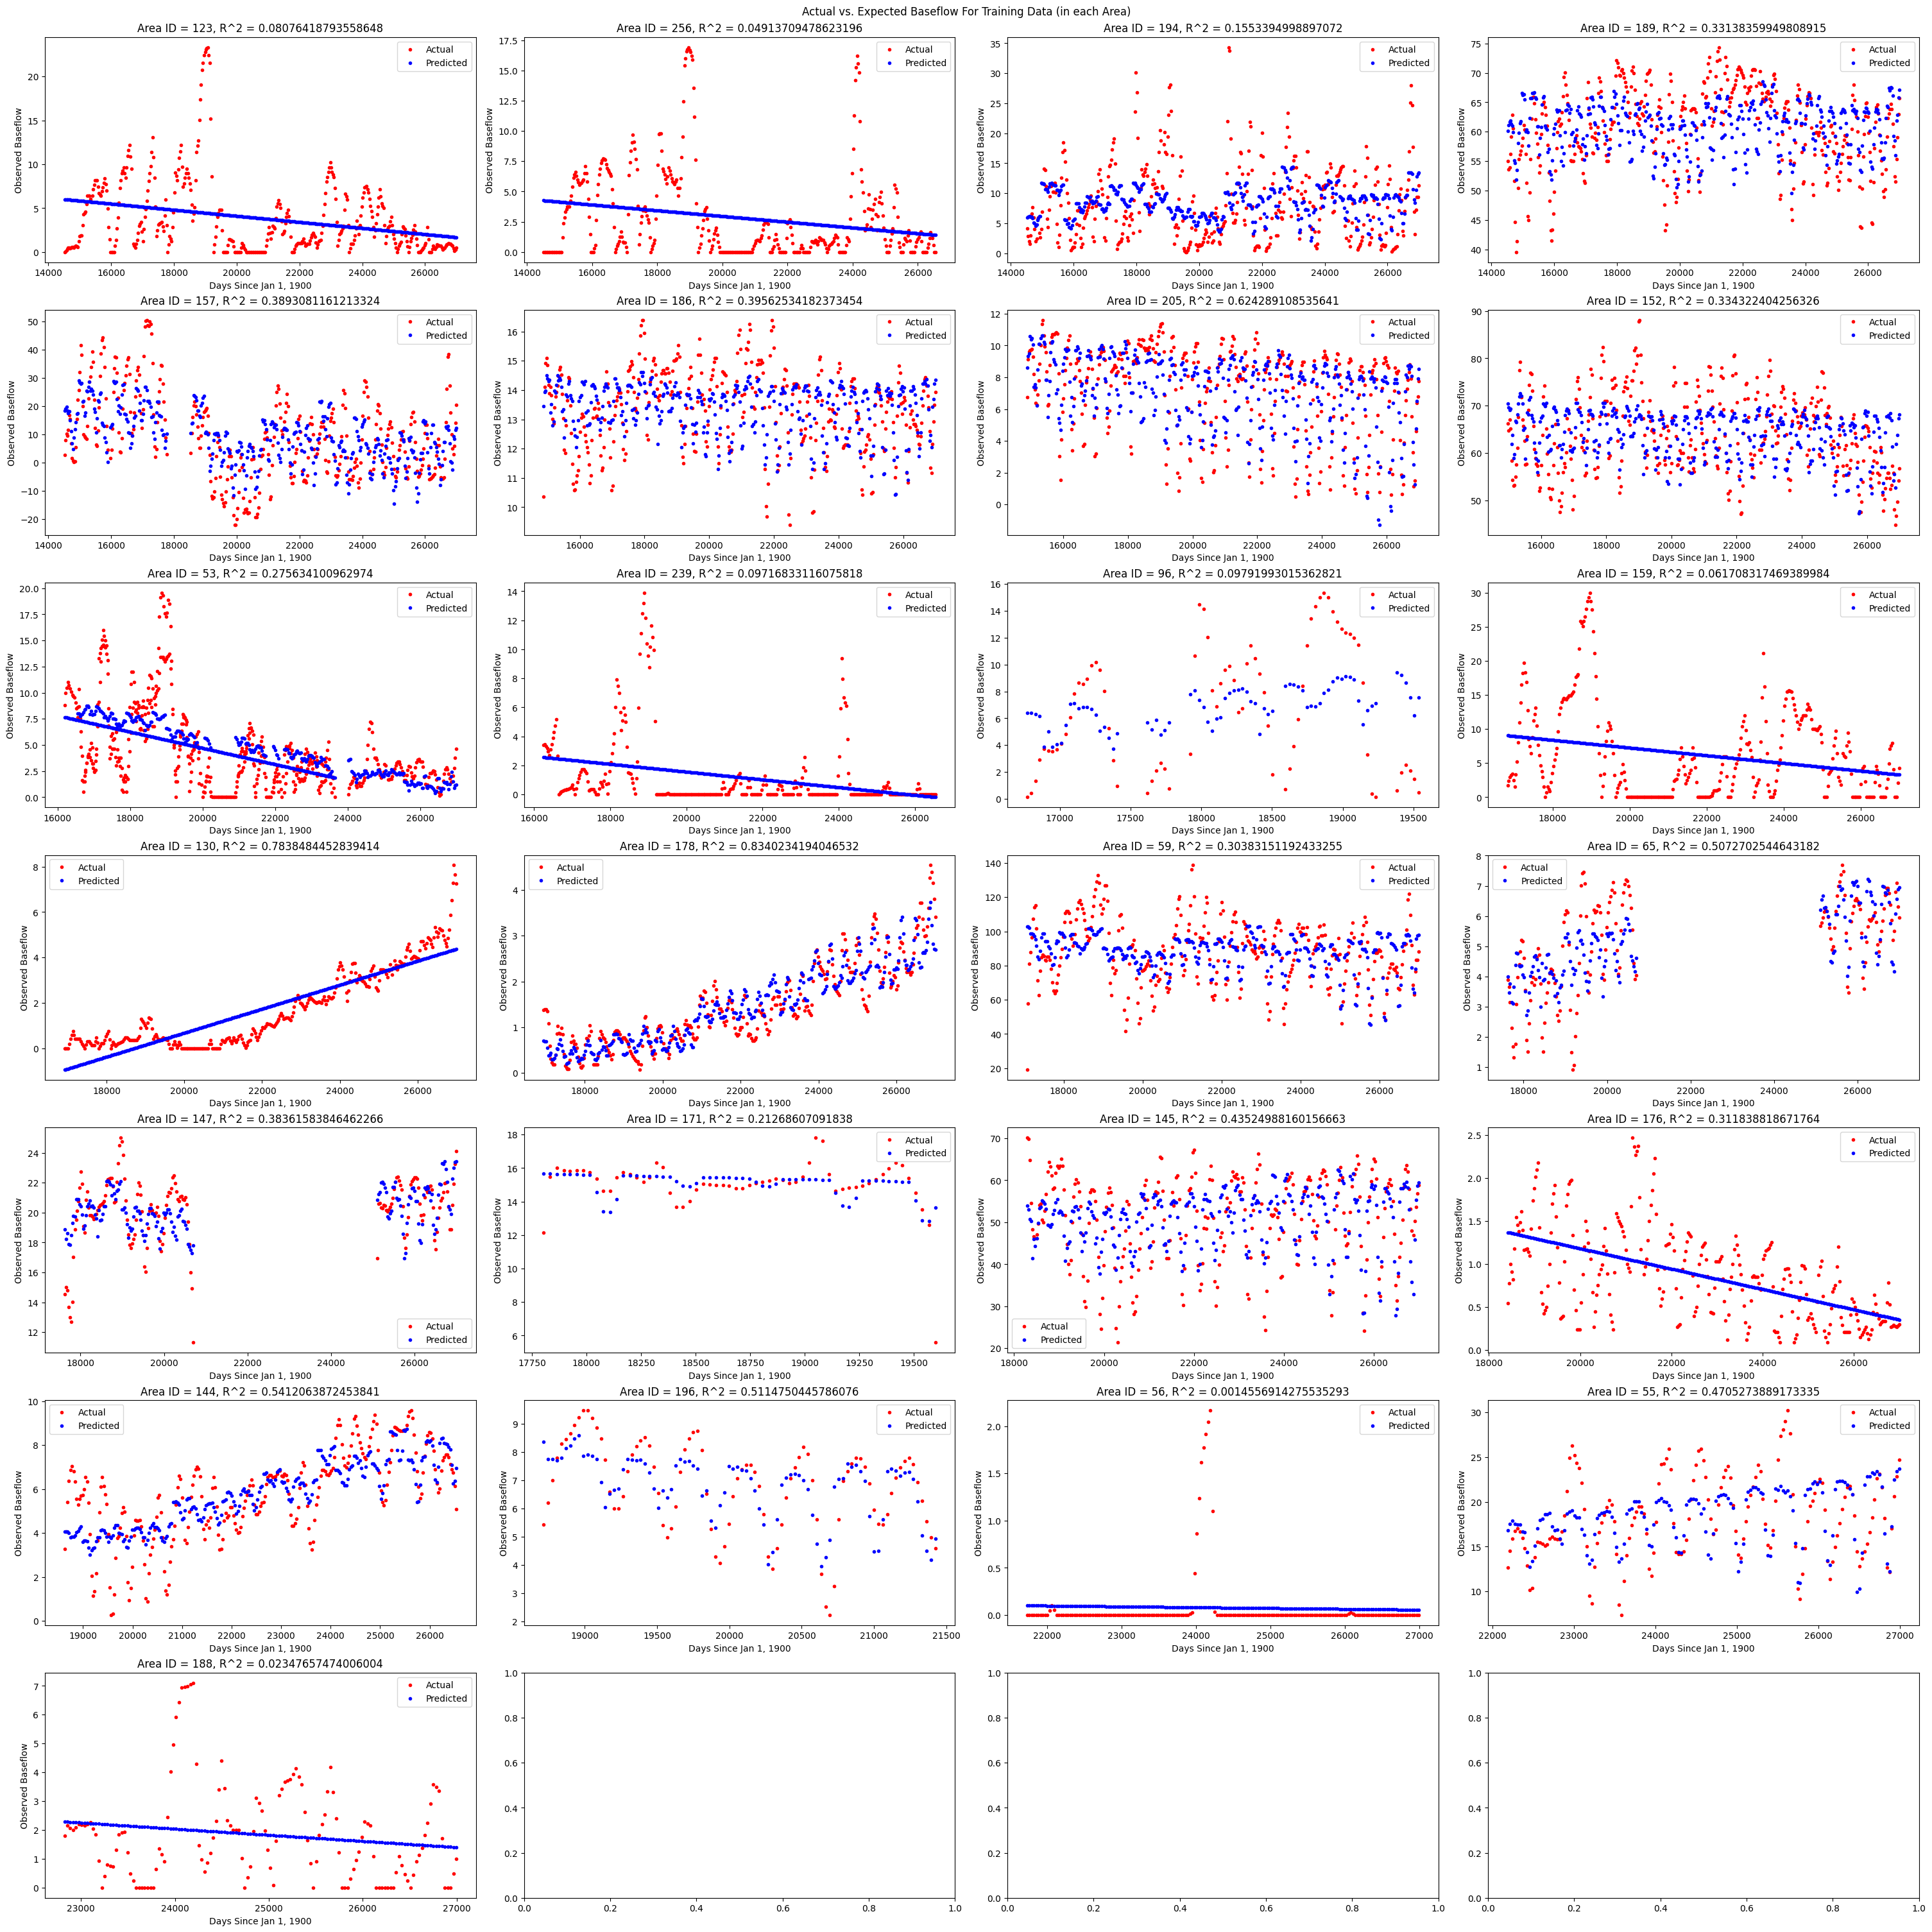

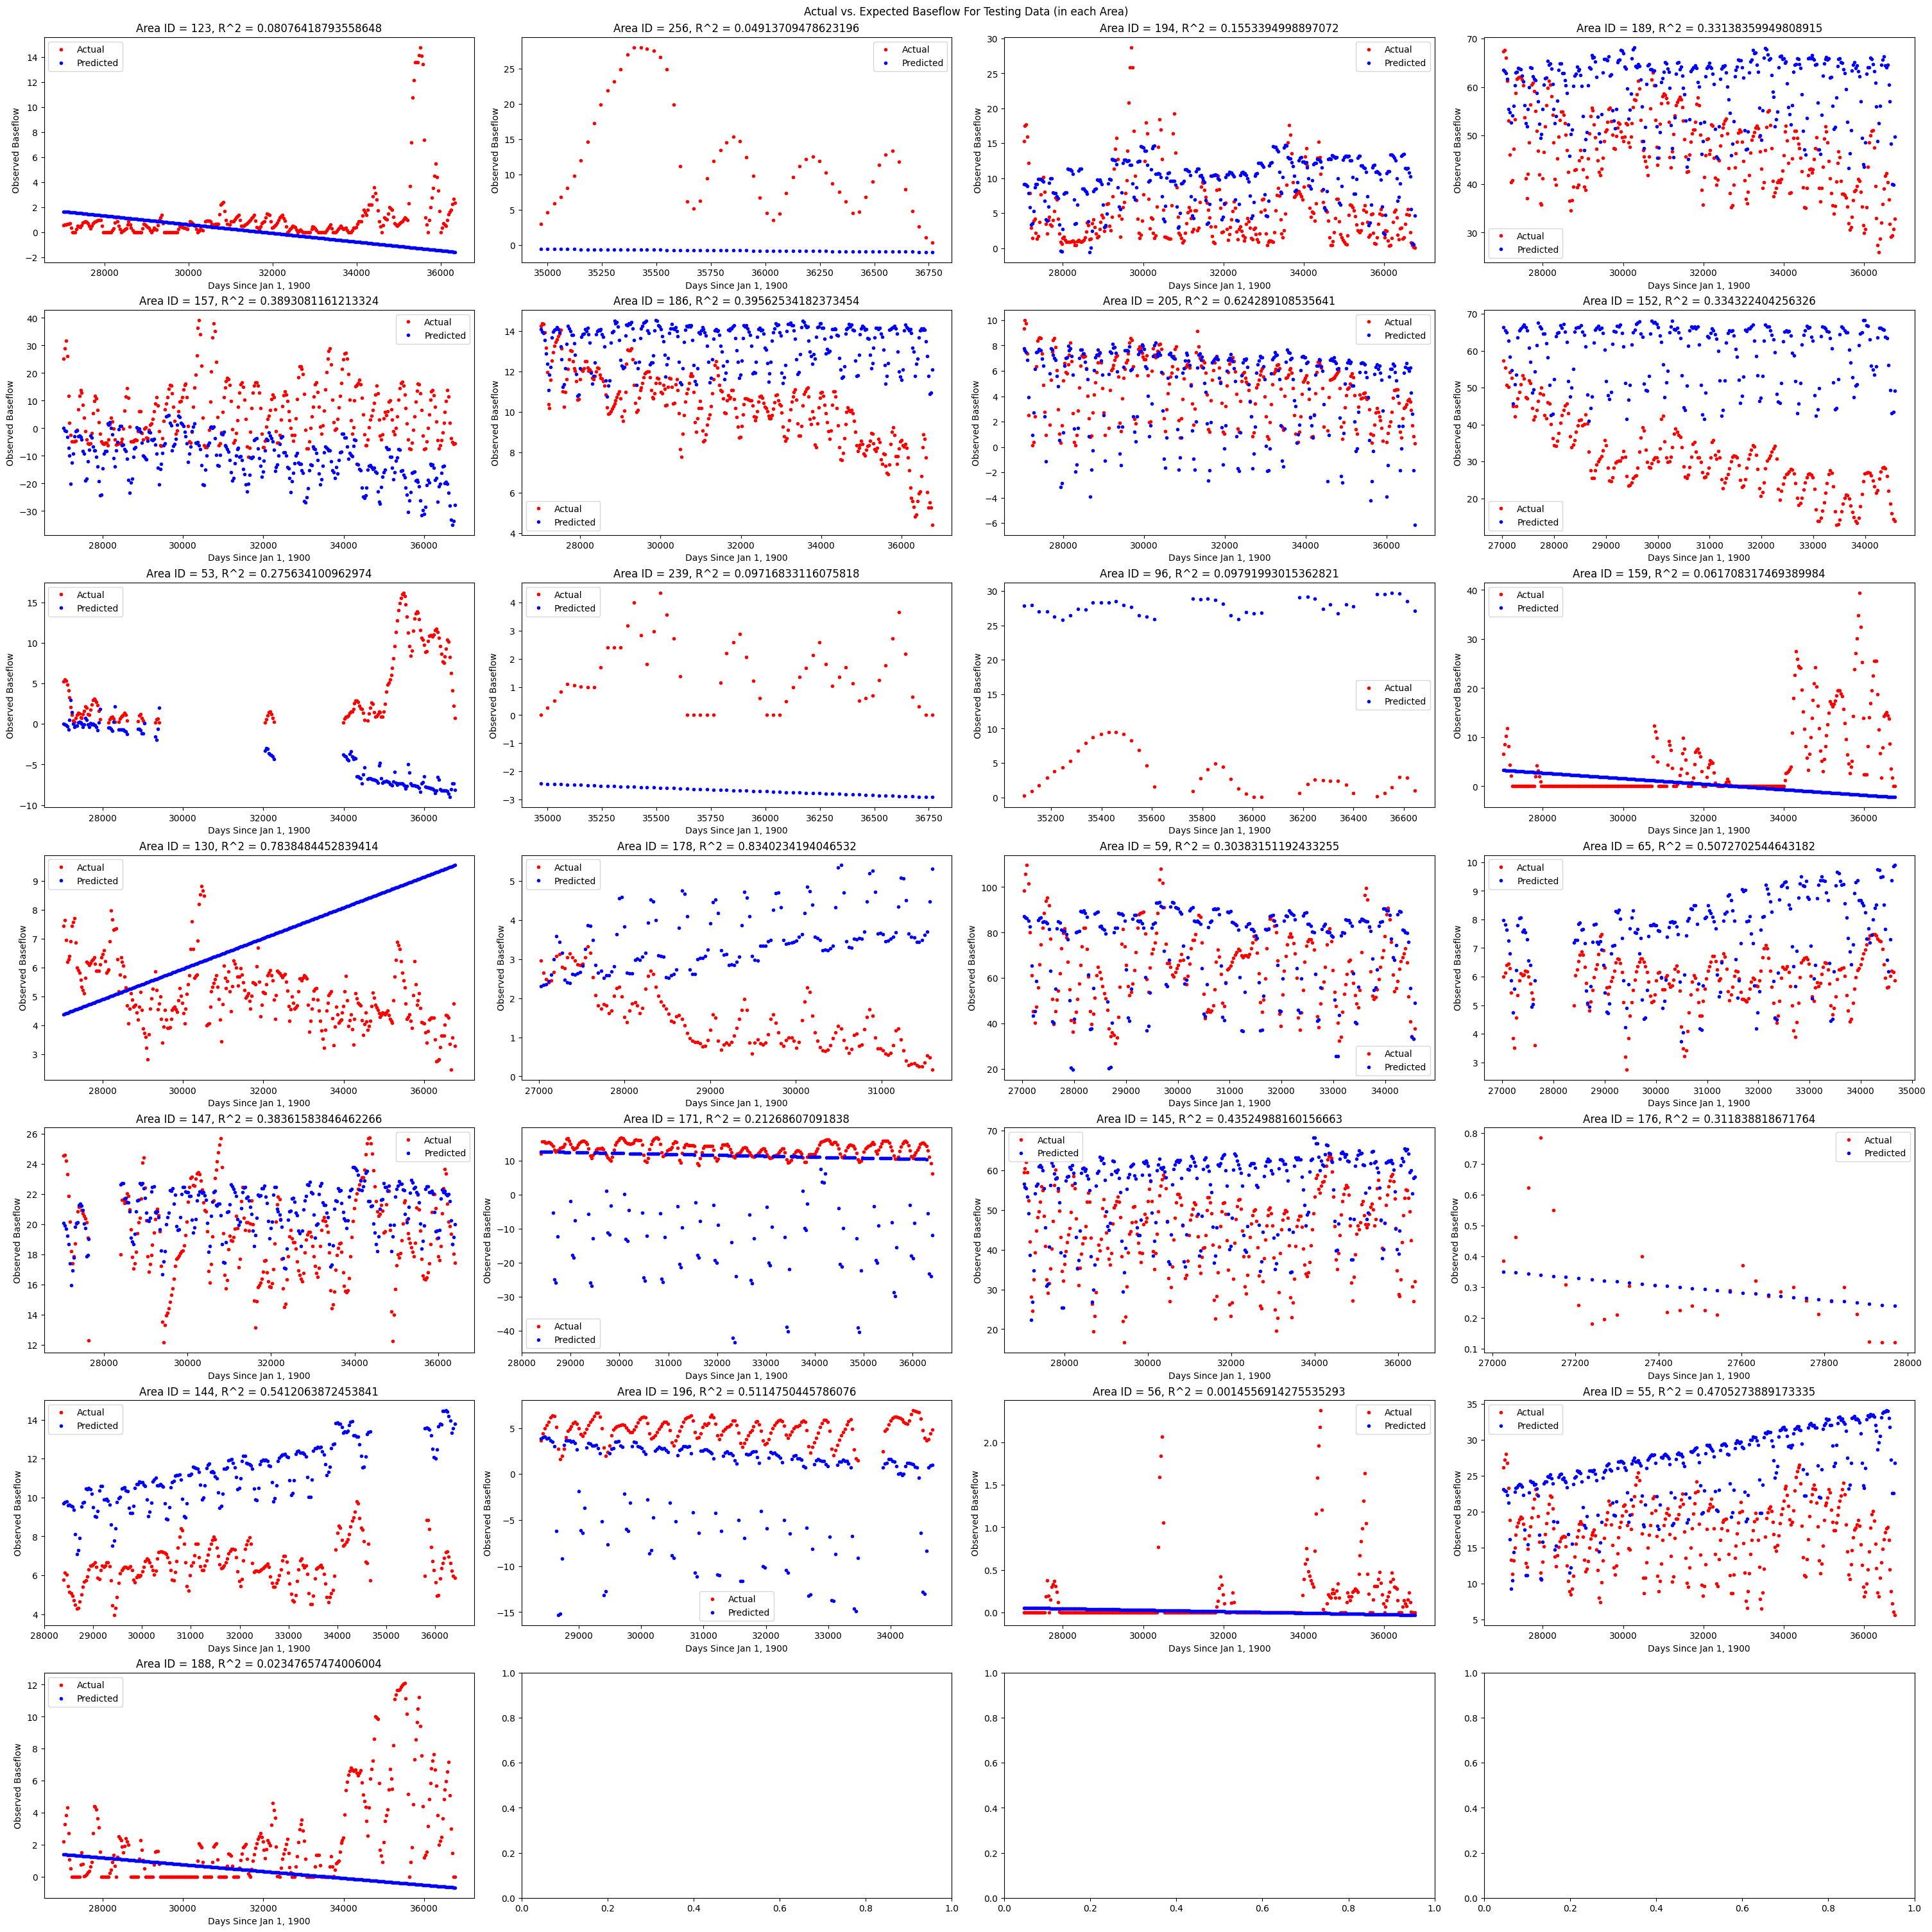

In [7]:
predictYVector = []
for i in range(len(testXVector)):
    predictYVector.append(models[i].predict(testXVector[i]))

figWidth = 4
figSize = (30,30)

# Plot actual vs. expected for training data
fig, ax = plt.subplots(len(testXVector)//figWidth+1,figWidth,figsize=figSize, layout='constrained')
for k in range(len(testXVector)):
    x_train = trainXVector[k]
    y_train = trainYVector[k]
    model = models[k]
    y_pred = model.predict(x_train)
    i = k // figWidth
    j = k - i * figWidth
    ax[i,j].plot(x_train['Date_Adjusted'], y_train.values,'.', color='red',label='Actual')
    ax[i,j].plot(x_train['Date_Adjusted'], y_pred, '.',color='blue', label='Predicted')
    ax[i,j].set_title(f"Area ID = {areas[k]}, R^2 = {scores[k]}")
    ax[i,j].set_xlabel("Days Since Jan 1, 1900")
    ax[i,j].set_ylabel("Observed Baseflow")
    ax[i,j].legend()
plt.suptitle("Actual vs. Expected Baseflow For Training Data (in each Area)")
plt.show()

# Plot actual vs. expected for test data
fig, ax = plt.subplots(len(testXVector)//figWidth+1,figWidth,figsize=figSize, layout='constrained')
for k in range(len(testXVector)):
    x_test = testXVector[k]
    y_test = testYVector[k]
    y_pred = predictYVector[k]
    i = k // figWidth
    j = k - i * figWidth
    ax[i,j].plot(x_test['Date_Adjusted'], y_test.values,'.', color='red',label='Actual')
    ax[i,j].plot(x_test['Date_Adjusted'], y_pred, '.',color='blue', label='Predicted')
    ax[i,j].legend()
    ax[i,j].set_title(f"Area ID = {areas[k]}, R^2 = {scores[k]}")
    ax[i,j].set_xlabel("Days Since Jan 1, 1900")
    ax[i,j].set_ylabel("Observed Baseflow")
plt.suptitle("Actual vs. Expected Baseflow For Testing Data (in each Area)")
plt.show()

# Does the Model Overestimate or Underestimate?

Take $y - \hat{y}$ for each point and divide by number of points. If this value is ~ 0, then the model is not consistently overestimating or underestimating. If the value is $< 0$, the model is consistently overestimating the baseflow. If the value is $> 0$, the model is consistently underestimating baseflow.

In [8]:
errorPerPointVector = [0 for _ in testYVector]
for i in range(len(testYVector)):
    predY = predictYVector[i]
    for j in range(len(predY)):
        errorPerPointVector[i] += testYVector[i].values[j] - predY[j]
    errorPerPointVector[i] /= len(predY)

areasWithError = list(zip(areas, errorPerPointVector, scores))

positive = [(area, error, score) for (area, error, score) in areasWithError if error > 1]
neutral = [(area, error, score) for (area, error, score) in areasWithError if error > -1 and error < 1]
negative = [(area, error, score) for (area, error, score) in areasWithError if error < -1]
display("Underestimation (area, error, R^2)", positive)
display("Overestimation (area, error, R^2)", negative)
display("Neither (area, error, R^2)", neutral)


'Underestimation (area, error, R^2)'

[(123, 1.110200277590972, 0.08076418793558648),
 (256, 12.775198476636712, 0.04913709478623196),
 (157, 17.298662719492757, 0.3893081161213324),
 (53, 8.99198765662632, 0.275634100962974),
 (239, 4.112907346689112, 0.09716833116075818),
 (159, 4.229030577103702, 0.061708317469389984),
 (171, 10.606300359632042, 0.21268607091838),
 (196, 5.925649198802051, 0.5114750445786076),
 (188, 2.0135910498836638, 0.02347657474006004)]

'Overestimation (area, error, R^2)'

[(194, -4.3653227130390615, 0.1553394998897072),
 (189, -12.806159530244276, 0.33138359949808915),
 (186, -3.18864295741499, 0.39562534182373454),
 (152, -28.751492629577285, 0.334322404256326),
 (96, -24.283205999795342, 0.09791993015362821),
 (130, -1.8711308166335592, 0.7838484452839414),
 (178, -2.072411428384599, 0.8340234194046532),
 (59, -8.44649957225098, 0.30383151192433255),
 (65, -1.5657858919522447, 0.5072702544643182),
 (147, -1.640559807258922, 0.38361583846462266),
 (145, -10.24078003050182, 0.43524988160156663),
 (144, -4.757003991969811, 0.5412063872453841),
 (55, -9.293203512213616, 0.4705273889173335)]

'Neither (area, error, R^2)'

[(205, 0.042323420371536476, 0.624289108535641),
 (176, 0.002456810875857904, 0.311838818671764),
 (56, 0.13140860976427493, 0.0014556914275535293)]

## Plot Each Area

Plot the x and y values of each area, and mark whether the model overestimated the baseflow, underestimated the baseflow, or neither.

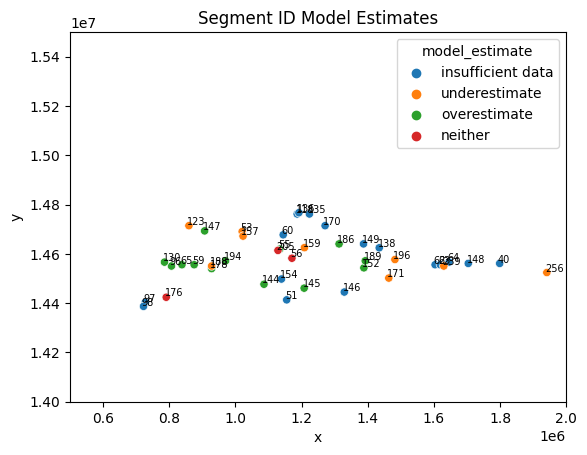

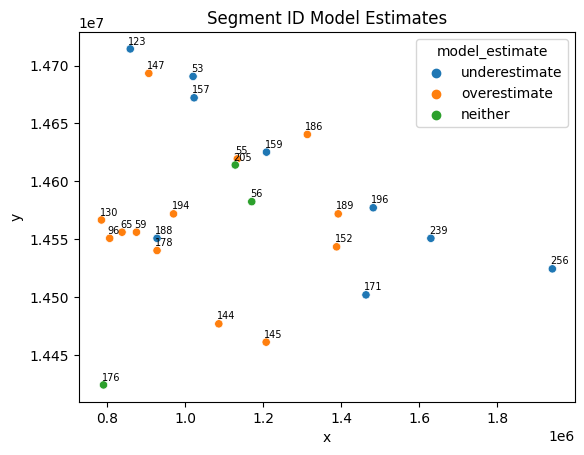

In [9]:
underestimateAreas = [area for (area, _, _) in positive]
overestimateAreas = [area for (area, _, _) in negative]
neutralAreas = [area for (area, _, _) in neutral]
model_estimate = []
for idx in baseflow.index:
    if baseflow['Segment_id'][idx] in overestimateAreas:
        model_estimate.append("overestimate")
    elif baseflow['Segment_id'][idx] in underestimateAreas:
        model_estimate.append('underestimate')
    elif baseflow['Segment_id'][idx] in neutralAreas:
        model_estimate.append('neither')
    else:
        model_estimate.append('insufficient data')
baseflow['model_estimate'] = model_estimate
plt.title("Segment ID Model Estimates")
window_size = 1.5e6
start_x = 0.5e6
start_y = 14.0e6
plt.xlim(start_x,start_x+window_size)
plt.ylim(start_y,start_y+window_size)
baseflow_by_seg_id = baseflow.groupby(by='Segment_id').agg({'x': 'mean', 'y': 'mean', 'model_estimate': 'max'})
# Plot first with areas which have insufficient data
scatterplot = sns.scatterplot(data=baseflow_by_seg_id, x='x', y='y', hue='model_estimate')
for id, row in baseflow_by_seg_id.iterrows():
    scatterplot.text(row['x']-5e3, row['y']+4e3, id, fontdict={'size': 7})
plt.show()
# Next, plot without areas which have insufficient data
plt.title("Segment ID Model Estimates")
# window_size = 1.5e6
# start_x = 0.5e6
# start_y = 14.0e6
# plt.xlim(start_x,start_x+window_size)
# plt.ylim(start_y,start_y+window_size)
baseflow_by_seg_id = baseflow_by_seg_id[baseflow_by_seg_id['model_estimate'] != 'insufficient data']
scatterplot = sns.scatterplot(data=baseflow_by_seg_id, x='x', y='y', hue='model_estimate')
for id, row in baseflow_by_seg_id.iterrows():
    scatterplot.text(row['x']-5e3, row['y']+4e3, id, fontdict={'size': 7})

Areas where the model **underestimates** baseflow are getting **more** baseflow than predicted by historical trends. Areas where thee model **overestimates** the baseflow are getting **less** baseflow than predicted by historical trends. Areas where the model neither overestimates nor underestimates baseflow are following historical trends.

**NOTICE:** There is a cluster of areas around Segment_id 59 (0.9e6, 1.455e7) for which the model has overestimated baseflow. Why is this? Here are a few ideas:

- That region is the North Fork of the Republican River, which is fed by the Arikaree River. 
  - The Arikaree River was designated a "Colorado Natural Area" (program started in 1977). This has the potential of affecting the flow to the North Fork of the Republican River.
  - The Arikaree River contains the lowest point in Colorado. Because of the Arikaree's low elevation, climate warming may be causing the snow which feeds the Arikaree to prematurely melt, resulting in a lower baseflow on the Republican.
  - The Arikaree also drains much of the land between the North and South forks of the Republican.
    - As demand for water grows on the Great Plains, landowners may be taking more water than historically from the Arikaree, resulting in a lower flow and as a result a lower baseflow in the North Fork of the Republican River.